## Project Code

In [7]:
library(repr)
library(tidyverse)
library(tidymodels)
install.packages("corrplot")
library(corrplot)
options(repr.matrix.max.rows = 6)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

corrplot 0.92 loaded



In [8]:
data = read_csv("WineQT.csv")
datacorr <- cor(data)


Rows: 1143 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (13): fixed acidity, volatile acidity, citric acid, residual sugar, chlo...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [9]:
corr <- cor(data)
round(corr, 2)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
fixed acidity,1.00,-0.25,0.67,0.17,0.11,-0.16,-0.11,0.68,-0.69,0.17,-0.08,0.12,-0.28
volatile acidity,-0.25,1.00,-0.54,-0.01,0.06,0.00,0.08,0.02,0.22,-0.28,-0.20,-0.41,-0.01
citric acid,0.67,-0.54,1.00,0.18,0.25,-0.06,0.04,0.38,-0.55,0.33,0.11,0.24,-0.14
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
alcohol,-0.08,-0.20,0.11,0.06,-0.23,-0.05,-0.19,-0.49,0.23,0.09,1.00,0.48,0.24
quality,0.12,-0.41,0.24,0.02,-0.12,-0.06,-0.18,-0.18,-0.05,0.26,0.48,1.00,0.07
Id,-0.28,-0.01,-0.14,-0.05,-0.09,0.10,-0.11,-0.36,0.13,-0.10,0.24,0.07,1.00


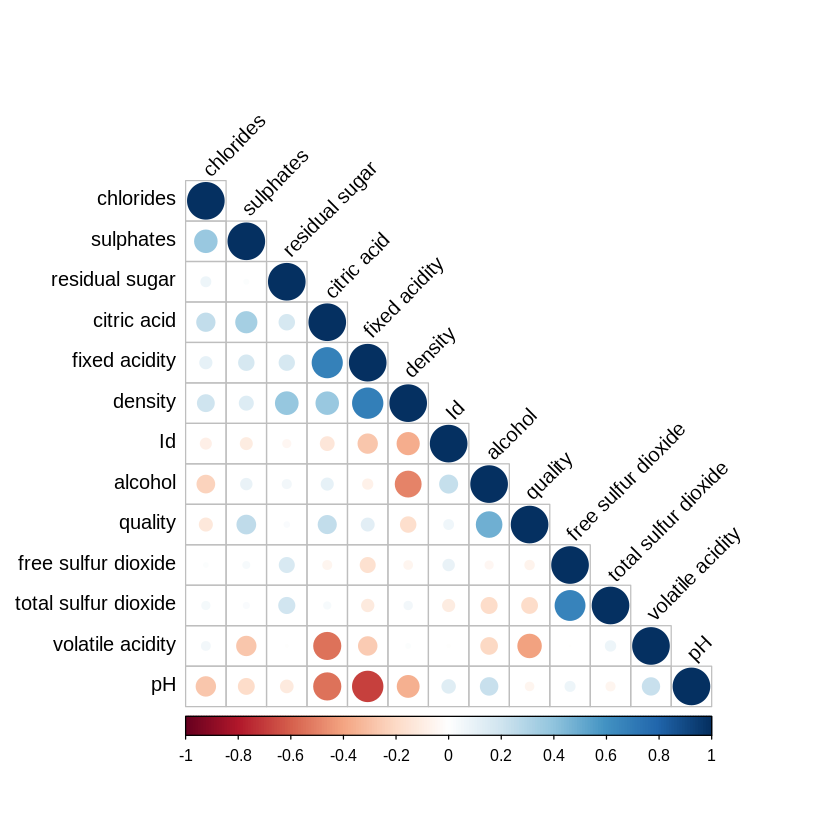

In [10]:
corrplot(corr, type = "lower", order = "hclust", 
         tl.col = "black", tl.srt = 45 )